In [1]:
import scipy.stats as ss
import numpy as np

In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import root
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm
from tqdm import tqdm

## Loading the Data:

In [3]:
start_date = '2019-01-01'
end_date = '2024-03-30'

# Filter the DataFrame
#filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

In [4]:
fx_data_raw = pd.read_excel("Yen-to-USD.xlsx")
fx_data_raw

,observation_date,DEXJPUS
0,1999-01-04,112.15
1,1999-01-05,111.15
2,1999-01-06,112.78
3,1999-01-07,111.69
4,1999-01-08,111.52
...,...,...
6585,2024-04-01,151.72
6586,2024-04-02,151.55
6587,2024-04-03,151.67
6588,2024-04-04,151.66


In [5]:
us_3months_treasury= pd.read_csv('US 3 month treasury.csv')
us_3months_treasury

,DATE,DTB3
0,2018-01-02,1.42
1,2018-01-03,1.39
2,2018-01-04,1.39
3,2018-01-05,1.37
4,2018-01-08,1.43
...,...,...
1629,2024-04-01,5.23
1630,2024-04-02,5.22
1631,2024-04-03,5.22
1632,2024-04-04,5.21


In [6]:
us_1year_treasury= pd.read_csv('US 1 year treasury rate.csv')
us_1year_treasury

,DATE,DGS1
0,2018-01-02,1.83
1,2018-01-03,1.81
2,2018-01-04,1.82
3,2018-01-05,1.80
4,2018-01-08,1.79
...,...,...
1629,2024-04-01,5.06
1630,2024-04-02,5.05
1631,2024-04-03,5.03
1632,2024-04-04,5.0


In [7]:
us_rates = pd.read_csv('US 10yr rates.csv')
us_rates

,DATE,DGS10
0,1999-01-04,4.69
1,1999-01-05,4.74
2,1999-01-06,4.73
3,1999-01-07,4.77
4,1999-01-08,4.86
...,...,...
6588,2024-04-04,4.31
6589,2024-04-05,4.39
6590,2024-04-08,4.42
6591,2024-04-09,4.36


In [8]:
japan_rates = pd.read_csv("Japan Rates Master File.csv")
japan_rates

,Date,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,15Y,20Y,25Y,30Y,40Y
0,1999-01-04,0.567,0.790,1.067,1.300,1.498,1.703,1.861,1.939,1.971,2.093,2.607,2.684,-,-,-
1,1999-01-05,0.548,0.758,1.025,1.255,1.448,1.646,1.802,1.881,1.919,2.040,2.550,2.643,-,-,-
2,1999-01-06,0.519,0.716,0.951,1.176,1.361,1.544,1.710,1.797,1.839,1.965,2.460,2.569,-,-,-
3,1999-01-07,0.469,0.633,0.817,1.022,1.193,1.358,1.520,1.615,1.664,1.803,2.268,2.410,-,-,-
4,1999-01-08,0.516,0.708,0.925,1.151,1.340,1.525,1.694,1.787,1.820,1.940,2.419,2.515,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6182,2024-03-25,0.063,0.206,0.221,0.307,0.401,0.417,0.486,0.573,0.653,0.752,1.163,1.493,1.664,1.796,1.944
6183,2024-03-26,0.063,0.207,0.221,0.302,0.396,0.418,0.491,0.577,0.657,0.757,1.168,1.497,1.662,1.791,1.94
6184,2024-03-27,0.055,0.204,0.211,0.287,0.384,0.404,0.472,0.556,0.638,0.738,1.145,1.472,1.632,1.763,1.921
6185,2024-03-28,0.054,0.196,0.205,0.277,0.368,0.389,0.457,0.541,0.624,0.730,1.124,1.458,1.617,1.75,1.904


#### Function for setting date as Index:

In [9]:
def index(df,col_name):
    df[col_name] = pd.to_datetime(df[col_name])
    df.set_index(col_name, inplace=True)
    df.index = pd.to_datetime(df.index)
    return df

In [10]:
fx_data_raw = index(fx_data_raw,'observation_date')
fx_data_raw

,DEXJPUS
observation_date,
1999-01-04,112.15
1999-01-05,111.15
1999-01-06,112.78
1999-01-07,111.69
1999-01-08,111.52
...,...
2024-04-01,151.72
2024-04-02,151.55
2024-04-03,151.67


In [11]:
nan_counts = fx_data_raw.isna().sum()
nan_counts

DEXJPUS    254
dtype: int64

In [12]:
us_rates = index(us_rates,'DATE')
us_rates

,DGS10
DATE,
1999-01-04,4.69
1999-01-05,4.74
1999-01-06,4.73
1999-01-07,4.77
1999-01-08,4.86
...,...
2024-04-04,4.31
2024-04-05,4.39
2024-04-08,4.42


In [13]:
us_rates['DGS10'] = us_rates['DGS10'].replace('.', np.nan)

In [14]:
nan_counts_us_rates = us_rates.isna().sum()
nan_counts_us_rates

DGS10    270
dtype: int64

In [15]:
japan_rates = index(japan_rates,'Date')


In [16]:
nan_counts_jpn_rates = japan_rates.isna().sum()
nan_counts_jpn_rates

1Y     0
2Y     0
3Y     0
4Y     0
5Y     0
6Y     0
7Y     0
8Y     0
9Y     0
10Y    0
15Y    0
20Y    0
25Y    0
30Y    0
40Y    0
dtype: int64

In [17]:
us_3months_treasury

,DATE,DTB3
0,2018-01-02,1.42
1,2018-01-03,1.39
2,2018-01-04,1.39
3,2018-01-05,1.37
4,2018-01-08,1.43
...,...,...
1629,2024-04-01,5.23
1630,2024-04-02,5.22
1631,2024-04-03,5.22
1632,2024-04-04,5.21


In [18]:
us_3months_treasury['DTB3'] = us_3months_treasury['DTB3'].replace('.', np.nan)

In [19]:
us_3months_treasury = index(us_3months_treasury,'DATE')

In [20]:
nan_counts_us_3m = us_3months_treasury.isna().sum()
nan_counts_us_3m

DTB3    68
dtype: int64

In [21]:
us_1year_treasury

,DATE,DGS1
0,2018-01-02,1.83
1,2018-01-03,1.81
2,2018-01-04,1.82
3,2018-01-05,1.80
4,2018-01-08,1.79
...,...,...
1629,2024-04-01,5.06
1630,2024-04-02,5.05
1631,2024-04-03,5.03
1632,2024-04-04,5.0


In [22]:
us_1year_treasury['DGS1'] = us_1year_treasury['DGS1'].replace('.', np.nan)

In [23]:
us_1year_treasury = index(us_1year_treasury,'DATE')

In [24]:
nan_counts_us_1y = us_1year_treasury.isna().sum()
nan_counts_us_1y

DGS1    68
dtype: int64

### Filling NAN values through interpolation

In [25]:
fx_data = fx_data_raw.interpolate(method='linear')

In [26]:
nan_counts_b = fx_data.isna().sum()
nan_counts_b

DEXJPUS    0
dtype: int64

In [27]:
us_rates['DGS10'] = pd.to_numeric(us_rates['DGS10'], errors='coerce')
us_rf = us_rates.interpolate(method='linear')
us_rf

,DGS10
DATE,
1999-01-04,4.69
1999-01-05,4.74
1999-01-06,4.73
1999-01-07,4.77
1999-01-08,4.86
...,...
2024-04-04,4.31
2024-04-05,4.39
2024-04-08,4.42


In [28]:
nan_counts_usrf = us_rf.isna().sum()
nan_counts_usrf

DGS10    0
dtype: int64

In [29]:
us_3months_treasury['DTB3'] = pd.to_numeric(us_3months_treasury['DTB3'], errors='coerce')
us_3m_rf = us_3months_treasury.interpolate(method='linear')
us_3m_rf

,DTB3
DATE,
2018-01-02,1.42
2018-01-03,1.39
2018-01-04,1.39
2018-01-05,1.37
2018-01-08,1.43
...,...
2024-04-01,5.23
2024-04-02,5.22
2024-04-03,5.22


In [30]:
us_1year_treasury['DGS1'] = pd.to_numeric(us_1year_treasury['DGS1'], errors='coerce')
us_1y_rf = us_1year_treasury.interpolate(method='linear')
us_1y_rf = us_1y_rf/100
us_1y_rf

,DGS1
DATE,
2018-01-02,0.0183
2018-01-03,0.0181
2018-01-04,0.0182
2018-01-05,0.0180
2018-01-08,0.0179
...,...
2024-04-01,0.0506
2024-04-02,0.0505
2024-04-03,0.0503


In [31]:
nan_counts_us3m = us_3m_rf.isna().sum()
nan_counts_us3m

DTB3    0
dtype: int64

In [32]:
nan_counts_us1y = us_1y_rf.isna().sum()
nan_counts_us1y

DGS1    0
dtype: int64

#### Calculating log returns for exchange rates

In [33]:
fx_data['Log_Returns'] = np.log(fx_data['DEXJPUS'] / fx_data['DEXJPUS'].shift(1))

In [34]:
fx_data

,DEXJPUS,Log_Returns
observation_date,,
1999-01-04,112.15,NaN
1999-01-05,111.15,-0.008957
1999-01-06,112.78,0.014558
1999-01-07,111.69,-0.009712
1999-01-08,111.52,-0.001523
...,...,...
2024-04-01,151.72,0.003301
2024-04-02,151.55,-0.001121
2024-04-03,151.67,0.000792


In [ ]:
# Filter the DataFrame for your dates of interest
#fx = fx_data.loc['2019-01-01':'2023-12-31']
#fx

In [35]:
nan_counts = fx_data.isna().sum()
nan_counts

DEXJPUS        0
Log_Returns    1
dtype: int64

In [36]:
fx_data.dropna(inplace=True)

In [37]:
fx_data

,DEXJPUS,Log_Returns
observation_date,,
1999-01-05,111.15,-0.008957
1999-01-06,112.78,0.014558
1999-01-07,111.69,-0.009712
1999-01-08,111.52,-0.001523
1999-01-11,108.83,-0.024417
...,...,...
2024-04-01,151.72,0.003301
2024-04-02,151.55,-0.001121
2024-04-03,151.67,0.000792


## Calculating Historical Volatility

In [38]:
window = 90
fx_data['Historical_Vol'] = fx_data['Log_Returns'].rolling(window).std() * np.sqrt(252)  # Annualizing volatility

## Splitting data from 2019 to 2024

In [39]:
# Filter the DataFrame for your dates of interest
fx = fx_data.loc[start_date:end_date]
us_rf = us_rf.loc[start_date:end_date]
us_1y = us_1y_rf.loc[start_date:end_date]
japan_rf = japan_rates.loc[start_date:end_date]

In [40]:
japan_1y_rf = japan_rf['1Y']/100
japan_1y_rf

Date
2019-01-04   -0.00173
2019-01-07   -0.00162
2019-01-08   -0.00146
2019-01-09   -0.00144
2019-01-10   -0.00147
               ...   
2024-03-25    0.00063
2024-03-26    0.00063
2024-03-27    0.00055
2024-03-28    0.00054
2024-03-29    0.00054
Name: 1Y, Length: 1277, dtype: float64

In [41]:
nan_counts_jpy = japan_rf.isna().sum()
nan_counts_jpy

1Y     0
2Y     0
3Y     0
4Y     0
5Y     0
6Y     0
7Y     0
8Y     0
9Y     0
10Y    0
15Y    0
20Y    0
25Y    0
30Y    0
40Y    0
dtype: int64

In [42]:
fx

,DEXJPUS,Log_Returns,Historical_Vol
observation_date,,,
2019-01-01,109.46,-0.002190,0.052472
2019-01-02,109.22,-0.002195,0.051230
2019-01-03,108.07,-0.010585,0.053323
2019-01-04,108.29,0.002034,0.053414
2019-01-07,108.62,0.003043,0.053559
...,...,...,...
2024-03-25,151.42,0.000462,0.100431
2024-03-26,151.58,0.001056,0.100328
2024-03-27,151.35,-0.001519,0.098375


In [43]:
us_rf

,DGS10
DATE,
2019-01-01,2.675
2019-01-02,2.660
2019-01-03,2.560
2019-01-04,2.670
2019-01-07,2.700
...,...
2024-03-25,4.250
2024-03-26,4.240
2024-03-27,4.200


In [44]:
nan_counts = fx.isna().sum()
nan_counts

DEXJPUS           0
Log_Returns       0
Historical_Vol    0
dtype: int64

In [45]:
fx_data = fx_data.reindex(us_1y.index)
fx_data['US 1 year']= us_1y['DGS1']
fx_data

,DEXJPUS,Log_Returns,Historical_Vol,US 1 year
DATE,,,,
2019-01-01,109.46,-0.002190,0.052472,0.02615
2019-01-02,109.22,-0.002195,0.051230,0.02600
2019-01-03,108.07,-0.010585,0.053323,0.02500
2019-01-04,108.29,0.002034,0.053414,0.02570
2019-01-07,108.62,0.003043,0.053559,0.02580
...,...,...,...,...
2024-03-25,151.42,0.000462,0.100431,0.05000
2024-03-26,151.58,0.001056,0.100328,0.05000
2024-03-27,151.35,-0.001519,0.098375,0.04990


In [46]:
fx_data = fx_data.reindex(japan_1y_rf.index)
fx_data['JPY 1 year'] = japan_1y_rf
fx_data

,DEXJPUS,Log_Returns,Historical_Vol,US 1 year,JPY 1 year
Date,,,,,
2019-01-04,108.29,0.002034,0.053414,0.02570,-0.00173
2019-01-07,108.62,0.003043,0.053559,0.02580,-0.00162
2019-01-08,108.57,-0.000460,0.053415,0.02600,-0.00146
2019-01-09,108.38,-0.001752,0.053462,0.02590,-0.00144
2019-01-10,108.29,-0.000831,0.052774,0.02590,-0.00147
...,...,...,...,...,...
2024-03-25,151.42,0.000462,0.100431,0.05000,0.00063
2024-03-26,151.58,0.001056,0.100328,0.05000,0.00063
2024-03-27,151.35,-0.001519,0.098375,0.04990,0.00055


In [47]:
nan_counts_fx_data = fx_data.isna().sum()
nan_counts

DEXJPUS           0
Log_Returns       0
Historical_Vol    0
dtype: int64

# Heston Model

In [48]:
def Heston_paths(N, paths, T, S0, v0, mu, rho, kappa, theta, sigma):
    """
    Generates random values of stock S and variance v at maturity T using the Heston model.
    This function uses the "abs" method for the variance.

    Parameters:
    int N = time steps
    int paths = number of paths
    double T = maturity
    double S0 = spot price
    double v0 = spot variance
    double mu = drift
    double rho = correlation coefficient
    double kappa = mean reversion coefficient
    double theta = long-term variance
    double sigma = Vol of Vol - Volatility of instantaneous variance

    Returns:
    Two arrays of size equal to "paths".
    """
    np.random.seed(42)
    dt = T / (N - 1)
    dt_sq = np.sqrt(dt)

    # Check the Feller condition
    assert 2 * kappa * theta > sigma ** 2, "Feller condition is not satisfied."

    v_T = np.zeros(paths)   # Values of v at T
    S_T = np.zeros(paths)   # Values of S at T

    for path in range(paths):
        # Generate random Brownian Motions
        W_S_arr = np.random.normal(loc=0, scale=np.sqrt(dt), size=N)
        W_v_arr = rho * W_S_arr + np.sqrt(1 - rho**2) * np.random.normal(loc=0, scale=np.sqrt(dt), size=N)

        S = np.zeros(N)
        v = np.zeros(N)
        S[0] = S0
        v[0] = v0

        for t in range(N - 1):
            v[t + 1] = np.abs(v[t] + kappa * (theta - v[t]) * dt + sigma * np.sqrt(v[t]) * dt_sq * W_v_arr[t])
            S[t + 1] = S[t] * np.exp((mu - 0.5 * v[t]) * dt + np.sqrt(v[t]) * dt_sq * W_S_arr[t])

        S_T[path] = S[-1]
        v_T[path] = v[-1]

    return S_T, v_T

In [49]:
spot_rates = fx_data['DEXJPUS'].values
risk_free_rates_usd = fx_data['US 1 year'].values
risk_free_rates_jpy = fx_data['JPY 1 year'].values
risk_free_rate_diff = risk_free_rates_usd#risk_free_rates_usd - risk_free_rates_jpy
historical_vol = fx_data['Historical_Vol'].values

In [50]:
r = 0.05  # drift
rho = -0.8  # correlation coefficient
kappa = 3  # mean reversion coefficient
theta = 0.1  # long-term mean of the variance
sigma = 0.25  # (Vol of Vol) - Volatility of instantaneous variance
T = 1  # Terminal time
K = 104.81  # Stike
v0 = 0.08  # spot variance
S0 = 108.29  # spot stock price
s1=[]
s2=[]
s3=[]
s4=[]
s5=[]
s6=[]

In [51]:
for i in range (len(spot_rates)):
    S, v = Heston_paths(N=100, paths=100, T=T, S0=spot_rates[i], v0=v0, mu=risk_free_rate_diff[i], rho=rho, kappa=kappa, theta=theta, sigma=risk_free_rate_diff[i])
    DiscountedPayoff1 = np.exp(-r * T) * np.maximum(S - 100, 0)
    DiscountedPayoff2 = np.exp(-r * T) * np.maximum(S -105, 0)
    DiscountedPayoff3 = np.exp(-r * T) * np.maximum(S - 110, 0)
    DiscountedPayoff4 = np.exp(-r * T) * np.maximum(S - 115, 0)
    DiscountedPayoff5 = np.exp(-r * T) * np.maximum(S - 120, 0)
    DiscountedPayoff6 = np.exp(-r * T) * np.maximum(S - 143.18, 0)
    V1 = np.mean(DiscountedPayoff1)
    V2 = np.mean(DiscountedPayoff2)
    V3 = np.mean(DiscountedPayoff3)
    V4 = np.mean(DiscountedPayoff4)
    V5 = np.mean(DiscountedPayoff5)
    V6 = np.mean(DiscountedPayoff6)
    s1.append(V1)
    s2.append(V2)
    s3.append(V3)
    s4.append(V4)
    s5.append(V5)
    s6.append(V6)

In [52]:
pay_off = pd.DataFrame()

In [53]:
pay_off['Date'] = fx_data.index
pay_off['spot']=spot_rates
pay_off['strike @ 100'] = s1
pay_off['strike @ 105'] = s2
pay_off['strike @ 110'] = s3
pay_off['strike @ 115'] = s4
pay_off['strike @ 120'] = s5
pay_off['strike @ 143.18'] = s6

In [75]:
pay_off = index(pay_off,'Date')
pay_off

,spot,strike @ 100,strike @ 105,strike @ 110,strike @ 115,strike @ 120,strike @ 143.18
Date,,,,,,,
2019-01-04,108.29,6.179477,2.136572,0.310566,0.000000,0.000000,0.000000
2019-01-07,108.62,6.491332,2.352450,0.369220,0.001973,0.000000,0.000000
2019-01-08,108.57,6.465380,2.334444,0.363958,0.001688,0.000000,0.000000
2019-01-09,108.38,6.281021,2.206492,0.329240,0.000000,0.000000,0.000000
2019-01-10,108.29,6.199183,2.149919,0.314195,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
2024-03-25,151.42,49.967939,45.211792,40.455645,35.699497,30.943350,8.936662
2024-03-26,151.58,50.121251,45.365104,40.608957,35.852810,31.096663,9.086078
2024-03-27,151.35,49.886358,45.130211,40.374063,35.617916,30.861769,8.857349


Garmen kolhagen 1

In [55]:
import numpy as np
from scipy.stats import norm

def black_scholes_call(S, K, r, T, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def black_scholes_put(S, K, r, T, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

def garman_kohlhagen_call(S, K, r_domestic, r_foreign, T, sigma):
    fwd = S * np.exp((r_foreign - r_domestic) * T)
    return black_scholes_call(fwd, K, r_domestic, T, sigma)

def garman_kohlhagen_put(S, K, r_domestic, r_foreign, T, sigma):
    fwd = S * np.exp((r_foreign - r_domestic) * T)
    return black_scholes_put(fwd, K, r_domestic, T, sigma)


In [69]:
spot_rates = fx_data['DEXJPUS'].values
risk_free_rates_usd = fx_data['US 1 year'].values
risk_free_rates_jpy = fx_data['JPY 1 year'].values
risk_free_rate_diff = risk_free_rates_usd - risk_free_rates_jpy
historical_vol = fx_data['Historical_Vol'].values
time_to_maturity = 1  # Time to maturity in years
specific_strikes = [100, 105, 110, 115,120,143.18]
#specific_strikes= [143.18,100]
dates = []  # Dates as index
call_prices = {}  # Dictionary to store call prices for each strike
put_prices = {}   # Dictionary to store put prices for each strike

# Parameters for Garman-Kohlhagen model
for date, spot_rate, r_usd, r_jpy, vol in zip(fx_data.index, spot_rates, risk_free_rates_usd, risk_free_rates_jpy, historical_vol):
    dates.append(date)
    for strike in specific_strikes:
        call_price = garman_kohlhagen_call(spot_rate, strike, r_usd, r_jpy, time_to_maturity, vol)
        put_price = garman_kohlhagen_put(spot_rate, strike, r_usd, r_jpy, time_to_maturity, vol)

        # Append call and put prices to respective dictionaries
        call_prices.setdefault(strike, []).append(call_price)
        put_prices.setdefault(strike, []).append(put_price)

# Create DataFrame from the collected data
df_bsgk = pd.DataFrame(index=dates)
for strike in specific_strikes:
    df_bsgk[f"call_price_{strike}"] = call_prices[strike]
    df_bsgk[f"put_price_{strike}"] = put_prices[strike]

# Display DataFrame
print(df_bsgk)

            call_price_100  put_price_100  call_price_105  put_price_105  \
2019-01-04        8.071372       0.174141        4.045535       1.021441   
2019-01-07        8.383495       0.154390        4.291737       0.935282   
2019-01-08        8.350184       0.154463        4.262563       0.938518   
2019-01-09        8.180581       0.166804        4.131461       0.989847   
2019-01-10        8.086529       0.163486        4.041635       0.990754   
...                    ...            ...             ...            ...   
2024-03-25       49.003033       0.000045       44.247222       0.000381   
2024-03-26       49.155323       0.000042       44.399493       0.000359   
2024-03-27       48.929759       0.000031       44.173384       0.000278   
2024-03-28       48.908751       0.000031       44.154278       0.000278   
2024-03-29       48.777745       0.000032       44.023995       0.000289   

            call_price_110  put_price_110  call_price_115  put_price_115  \
2019-01-04 

In [70]:
df_bsgk

,call_price_100,put_price_100,call_price_105,put_price_105,call_price_110,put_price_110,call_price_115,put_price_115,call_price_120,put_price_120,call_price_143.18,put_price_143.18
2019-01-04,8.071372,0.174141,4.045535,1.021441,1.459061,3.308105,0.354671,7.076851,0.056773,11.652091,8.261822e-08,34.187182
2019-01-07,8.383495,0.154390,4.291737,0.935282,1.595872,3.112067,0.403110,6.791955,0.067434,11.328929,1.247218e-07,33.851100
2019-01-08,8.350184,0.154463,4.262563,0.938518,1.576819,3.124449,0.395120,6.814426,0.065383,11.356364,1.115076e-07,33.876069
2019-01-09,8.180581,0.166804,4.131461,0.989847,1.506374,3.236922,0.371194,6.973905,0.060351,11.535224,9.552166e-08,34.062220
2019-01-10,8.086529,0.163486,4.041635,0.990754,1.443528,3.264810,0.343997,7.037442,0.053367,11.618974,5.857759e-08,34.152953
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-25,49.003033,0.000045,44.247222,0.000381,39.493077,0.002383,34.746036,0.011489,30.022576,0.044177,1.044494e+01,2.516041
2024-03-26,49.155323,0.000042,44.399493,0.000359,39.645249,0.002263,34.897825,0.010986,30.173195,0.042503,1.055153e+01,2.470341
2024-03-27,48.929759,0.000031,44.173384,0.000278,39.418341,0.001859,34.669326,0.009466,29.941322,0.038085,1.029108e+01,2.439544
2024-03-28,48.908751,0.000031,44.154278,0.000278,39.401137,0.001858,34.654022,0.009463,29.927910,0.038072,1.028577e+01,2.438821


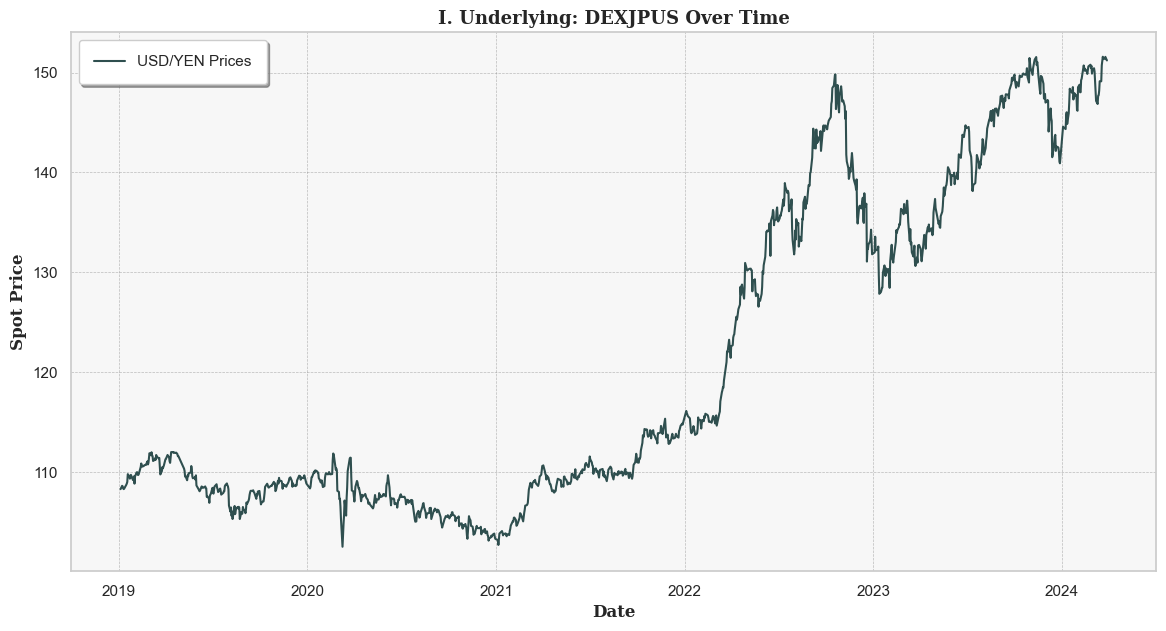

In [71]:
import seaborn as sns

plt.figure(figsize=(14,7))
plt.plot(fx_data.index, fx_data['DEXJPUS'], label='USD/YEN Prices', color='darkslategrey', linestyle='-')

#plt.plot(data_df.index, data_df['corporate_price'], label='Corporate Prices', color='maroon', linestyle='--')

# Add labels and title
plt.xlabel('Date',fontsize=12, fontweight='bold',fontfamily='serif')
plt.ylabel('Spot Price',fontsize=12, fontweight='bold',fontfamily='serif')
plt.title('I. Underlying: DEXJPUS Over Time',fontsize=13, fontweight='bold',fontfamily='serif')

# Add legend with fancy box border
plt.legend(loc='upper left', fancybox=True, framealpha=1, shadow=True, borderpad=1)

# Add grid for better readability
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

# Customize background color
plt.gca().set_facecolor('#f7f7f7')

# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

# Show plot
plt.show()


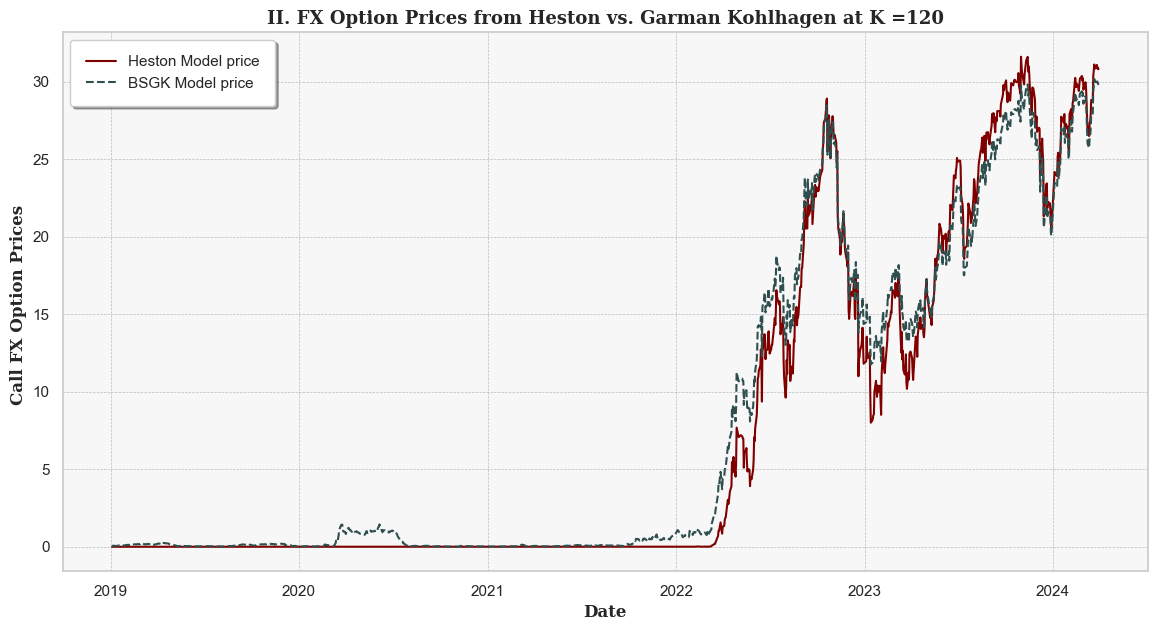

In [77]:

plt.figure(figsize=(14, 7))
plt.plot(pay_off.index, pay_off['strike @ 120'], label='Heston Model price', color ="maroon")
plt.plot(df.index, df['call_price_120'], label='BSGK Model price', linestyle= '--',color ="darkslategrey")
plt.xlabel('Date',fontsize=12, fontweight='bold',fontfamily='serif')
plt.ylabel('Call FX Option Prices ',fontsize=12, fontweight='bold',fontfamily='serif')
plt.title('II. FX Option Prices from Heston vs. Garman Kohlhagen at K =120',fontsize=13, fontweight='bold',fontfamily='serif')

# Add legend with fancy box border
plt.legend(loc='upper left', fancybox=True, framealpha=1, shadow=True, borderpad=1)

# Add grid for better readability
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

# Customize background color
plt.gca().set_facecolor('#f7f7f7')

# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

# Show plot
plt.show()


In [ ]:
!pip install whittaker-eilers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.0 MB/s eta 0:00:00


In [60]:
from whittaker_eilers import WhittakerSmoother
bsgk_smooth = WhittakerSmoother(lmbda=1, order=2, data_length=len(df['call_price_120']))
bsgk_smooth_price = bsgk_smooth.smooth(df['call_price_120'])
heston_smooth = WhittakerSmoother(lmbda=1, order=2, data_length=len(pay_off['strike @ 120']))
heston_smooth_price = heston_smooth.smooth(pay_off['strike @ 120'])

In [ ]:
#bsgk_smooth_price

In [61]:
#pay_off.set_index('Date', inplace=True)
#diff = df['call_price_120']- pay_off['strike @ 120']
#diff = bsgk_smooth_price- pay_off['strike @ 120']
diff = np.array(bsgk_smooth_price) - np.array(heston_smooth_price)


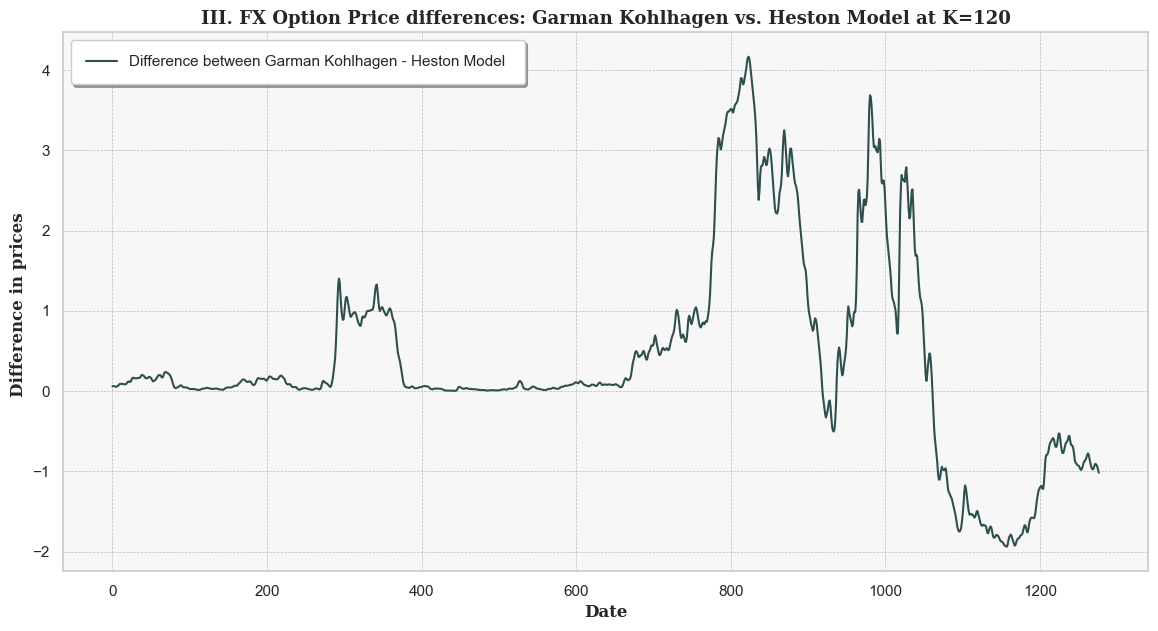

In [62]:
# Plot historical vs calibrated volatilities
plt.figure(figsize=(14, 7))
#df['diff'] = df['call_price_120']- pay_off['strike @ 120']
plt.plot(pay_off.index, diff , label='Difference between Garman Kohlhagen - Heston Model ', color = 'darkslategrey')
plt.xlabel('Date',fontsize=12, fontweight='bold',fontfamily='serif')
plt.ylabel('Difference in prices ',fontsize=12, fontweight='bold',fontfamily='serif')
plt.title('III. FX Option Price differences: Garman Kohlhagen vs. Heston Model at K=120',fontsize=13, fontweight='bold',fontfamily='serif')

# Add legend with fancy box border
plt.legend(loc='upper left', fancybox=True, framealpha=1, shadow=True, borderpad=1)

# Add grid for better readability
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

# Customize background color
plt.gca().set_facecolor('#f7f7f7')

# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

# Show plot
plt.show()

In [63]:
risk_free_rates_usd = fx_data['US 1 year'].values
risk_free_rates_jpy = fx_data['JPY 1 year'].values
risk_free_rate_diff = risk_free_rates_usd - risk_free_rates_jpy
fx_data['r_diff']= risk_free_rate_diff

In [64]:
fx_data

,DEXJPUS,Log_Returns,Historical_Vol,US 1 year,JPY 1 year,r_diff
Date,,,,,,
2019-01-04,108.29,0.002034,0.053414,0.02570,-0.00173,0.02743
2019-01-07,108.62,0.003043,0.053559,0.02580,-0.00162,0.02742
2019-01-08,108.57,-0.000460,0.053415,0.02600,-0.00146,0.02746
2019-01-09,108.38,-0.001752,0.053462,0.02590,-0.00144,0.02734
2019-01-10,108.29,-0.000831,0.052774,0.02590,-0.00147,0.02737
...,...,...,...,...,...,...
2024-03-25,151.42,0.000462,0.100431,0.05000,0.00063,0.04937
2024-03-26,151.58,0.001056,0.100328,0.05000,0.00063,0.04937
2024-03-27,151.35,-0.001519,0.098375,0.04990,0.00055,0.04935
